# Gauging Sentiment of Emerging Apple and Google Technology on Twitter

## Business Problem

Gauging sentiment of a market sector, company, or product is very helpful to investment analysis. An invetment firm is analyszing emerging technology and would like a predictive model that can analyze text data to classify the sentiment; poitive or negative. Being able to gauge overall sentiment will help in analysis of the sector and help them strategically place investments in the market.

## Data Understanding

The dataset consists of thousands of tweets from the SXSW festival pertaining to Apple and Google products. The tweets are labeled as positive, negative, no opinion, or "I can't tell." We will analyze the data from a binary classification standpoint and only keep the positive and negative classes.

The data is heavily imbalanced with positive tweets outnumbering the negative by a 6:1 ratio.

## Methods

Using NLP methods we will pre-process the data to get it ready for modeling.
> 1. First, we will clean the data by removing stop words, punctuation and other pieces of text that do not add value to the analysis such as numbers, and twitter slang.
> 2. Then we will tokenize he text with regular expressions
> 3. Next we will both stem and lemmatize the text separatley so that we can train models on both and see which is better.
> 4. Finally we will vectorize the text with both TF-IDF and Count vectorization ao that we again can see which will provide a better model.

We will split our dataset into trainign and testing data, and to handle the imbalance we with use SMOTE to provide a balanced traning set. 

Once the data is ready for modeling we will build a baseline and then train several models, score them with cross validation, and generate predictions from our models and compare them with our test set to attain our final results.

In [1]:
# Import our dependencies
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
import string
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from collections import Counter
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

# EDA

In [2]:
# Read in our dataset and view the first 5 rows
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# View our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [4]:
# See the various products and companies the tweets are about
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
# Get a feel for the class labels
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Data Cleaning

In [6]:
# Since we are analyzing sentiment we will drop the labels with no sentiment
pos_neg = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
pos_neg = pos_neg[pos_neg['is_there_an_emotion_directed_at_a_brand_or_product'] != "No emotion toward brand or product"]

>Extremely unbalanced dataset

In [7]:
pos_neg.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [8]:
# Drop the products/companies column since we will not be using this in our text analysis
# Change column names to something short and easier to work with
pos_neg = pos_neg.drop('emotion_in_tweet_is_directed_at', axis=1)
pos_neg = pos_neg.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product':'target'})
pos_neg.head()

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [9]:
# Create a function to remove Twitter lingo like @'s and #'s and map it on our text column
def remove_ats_and_hashtags(text):
    entity_prefixes = ['@','#','�']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

pos_neg['text'] = pos_neg['text'].map(remove_ats_and_hashtags)

In [10]:
# Encode our classes/targets for modeling
pos_neg.replace({'Negative emotion' : 0, 'Positive emotion' : 1}, inplace=True)

In [11]:
# Tansform our text to all lower case letters
pos_neg['text'] = pos_neg['text'].str.lower()
pos_neg.head()

,text,target
0,i have a 3g iphone after 3 hrs tweeting at aus...,0
1,know about awesome ipad iphone app that you ll...,1
2,can not wait for 2 also they should sale them ...,1
3,i hope this year s festival isn t as crashy as...,0
4,great stuff on fri marissa mayer google tim o ...,1


### Explore the words

In [18]:
# Tokenize our text to split into words
pos_neg['text_tokenized'] = pos_neg['text'].apply(word_tokenize)

In [19]:
# Create a function that will view the 20 most frequently used words
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)

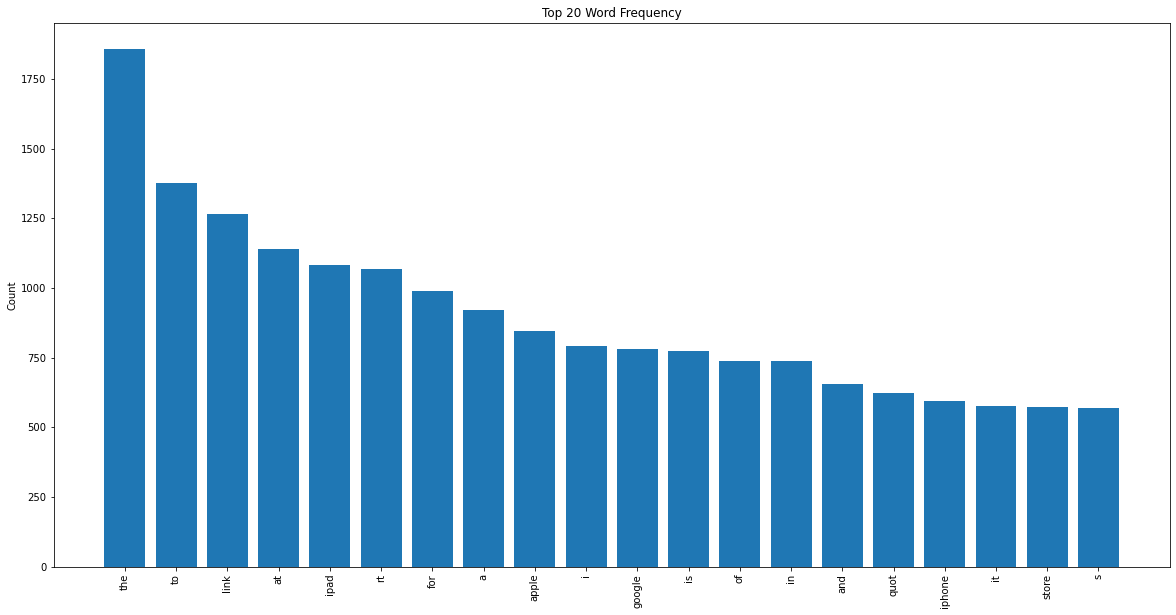

In [20]:
# create a frequency distribution and view it as a histogram
pos_neg_freq_dist = FreqDist(pos_neg['text_tokenized'].explode())

visualize_top_20(pos_neg_freq_dist, "Top 20 Word Frequency")

There are a number of stopwords, 1 character and other phrases that won't add value to our model.

### Remove stopwords, punctuation and other unwanted phrases



In [21]:
# Create a stopwrods list for removal, add punctuation and other phrases to drop
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
new_stops = ('quot', 'rt', 'i')
stopwords_list += list(new_stops)

In [22]:
# Create a function that will remove the stopwords list from the text and apply it to our text
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are in stopwords_list have been removed
    """
    stops_rmv_list = [token for token in token_list if token not in stopwords_list]
    return stops_rmv_list

pos_neg['stopwords_removed'] = pos_neg['text_tokenized'].apply(remove_stopwords)

In [23]:
# Remove numbers and single letters and create a text column for modeling
pattern = "([a-z]{2,})"
regex_tokenizer = RegexpTokenizer(pattern)

pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.stopwords_removed]
pos_neg['regex_text_tokenized'] = [regex_tokenizer.tokenize(text) for text in pos_neg['regex_text']]
pos_neg['regex_text'] = [' '.join(text) for text in pos_neg.regex_text_tokenized]

In [24]:
pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up..."
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app..."
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]"
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]"
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti..."


### Stem Words

In [25]:
snow_stemmer = SnowballStemmer(language="english")

pos_neg['stemmed_text'] = [snow_stemmer.stem(text) for text in pos_neg['regex_text']]

pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up...",iphone hrs tweeting austin dead need upgrade p...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...


### Lemmatize words

In [26]:
lemmer = WordNetLemmatizer()

pos_neg['lemmed_text'] = [lemmer.lemmatize(text) for text in pos_neg['regex_text']]

pos_neg.head()

,text,target,text_tokenized,stopwords_removed,regex_text,regex_text_tokenized,stemmed_text,lemmed_text
0,i have a 3g iphone after 3 hrs tweeting at aus...,0,"[i, have, a, 3g, iphone, after, 3, hrs, tweeti...","[3g, iphone, 3, hrs, tweeting, austin, dead, n...",iphone hrs tweeting austin dead need upgrade p...,"[iphone, hrs, tweeting, austin, dead, need, up...",iphone hrs tweeting austin dead need upgrade p...,iphone hrs tweeting austin dead need upgrade p...
1,know about awesome ipad iphone app that you ll...,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,can not wait for 2 also they should sale them ...,1,"[can, not, wait, for, 2, also, they, should, s...","[wait, 2, also, sale]",wait also sale,"[wait, also, sale]",wait also sal,wait also sale
3,i hope this year s festival isn t as crashy as...,0,"[i, hope, this, year, s, festival, isn, t, as,...","[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app,hope year festival crashy year iphone app
4,great stuff on fri marissa mayer google tim o ...,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...


### View the new frequency distribution of words after processing

In [28]:
pos_neg['lemmed_text_tokenized'] = pos_neg['lemmed_text'].apply(word_tokenize)

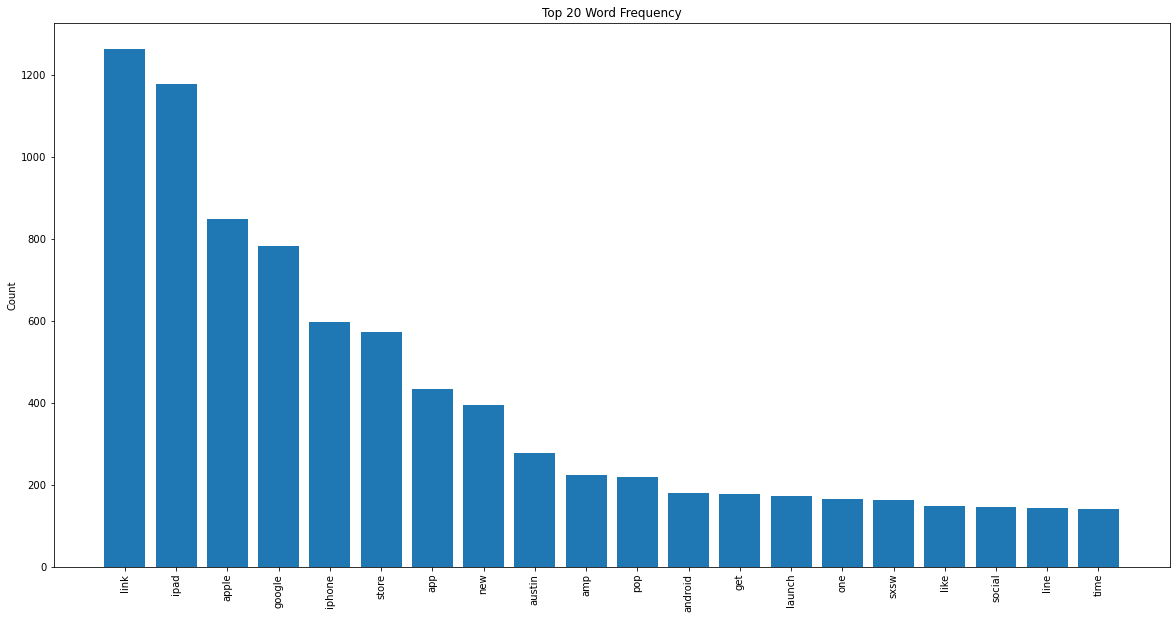

In [29]:
# create a frequency distribution and view it as a histogram
lemmed_text_freq_dist = FreqDist(pos_neg['lemmed_text_tokenized'].explode())

visualize_top_20(lemmed_text_freq_dist, "Top 20 Word Frequency")

### Train Test Split

In [30]:
X = pos_neg.drop(['target'], axis=1)
y = pos_neg['target']

X_train , X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [31]:
y_train.value_counts(normalize=True)

1    0.840352
0    0.159648
Name: target, dtype: float64

### Build and score a baseline model

#### Using Count Vectorization

In [78]:
# Use count vectorization
count = CountVectorizer()
X_count_vectorized = count.fit_transform(X_train['lemmed_text'])

In [79]:
# With such an imbalanced dataset use SMOTE to balance training data
smote_count = SMOTE(k_neighbors=3)
X_train_resampled, y_train_resampled = smote_count.fit_resample(
    X_count_vectorized, y_train)

In [80]:
# Instantiate a MultinomialNB classifier and fi it to training data
baseline_model = MultinomialNB()

baseline_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
baseline_cv = cross_val_score(baseline_model, X_train_resampled, y_train_resampled)
print("Baseline:", baseline_cv.mean())

Baseline: 0.8115468409586055


In [81]:
y_train_resampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

In [91]:
# Use count vectorization with only bigrams
count_bigram = CountVectorizer(ngram_range=(2,2))
X_count_vectorized_bigrams = count_bigram.fit_transform(X_train['lemmed_text'])

In [92]:
smote_count = SMOTE(k_neighbors=3)
X_train_resampled_bigram, y_train_resampled_bigram = smote_count.fit_resample(
    X_count_vectorized_bigrams, y_train)

In [94]:
baseline_model_bigram = MultinomialNB()

baseline_model_bigram.fit(X_train_resampled_bigram, y_train_resampled_bigram)

baseline_bigram_cv = cross_val_score(baseline_model_bigram, X_train_resampled_bigram, y_train_resampled_bigram)
print("Baseline         :", baseline_cv.mean())
print("Baseline bigrams :", baseline_bigram_cv.mean())

Baseline         : 0.8115468409586055
Baseline bigrams : 0.7387799564270152


#### Using TF-IDF Vectorization

In [95]:
tfidf = TfidfVectorizer(max_features=60)
X_train_vectorized_tfidf = tfidf.fit_transform(X_train['lemmed_text'])

In [96]:
smote_count = SMOTE(k_neighbors=3)
X_train_resampled_tfidf, y_train_resampled_tfidf = smote_count.fit_resample(
    X_train_vectorized_tfidf, y_train)

In [97]:
baseline_model_tfidf = MultinomialNB()

baseline_model_tfidf.fit(X_train_resampled_tfidf, y_train_resampled_tfidf)

baseline_tfidf_cv = cross_val_score(baseline_model_tfidf, X_train_resampled_tfidf, y_train_resampled_tfidf)
print("Baseline         :", baseline_cv.mean())
print("Baseline bigrams :", baseline_bigram_cv.mean())
print("Baseline TF-IDF  :", baseline_tfidf_cv.mean())

Baseline         : 0.8115468409586055
Baseline bigrams : 0.7387799564270152
Baseline TFIDF   : 0.6858387799564271
